In [1]:
'''
This file is the 6th to be executed
This file vizualises and calculates the networks 
'''
import pandas as pd
import numpy as np
import networkx as nx
import community
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from collections import defaultdict



In [2]:
df = pd.read_csv('data/comments_final.csv')
len(df)

134883

In [3]:
# Filter comments with non-zero parentId or totalReplyCount
graph_data = df[(df['parentID'] != "0") | (df['totalReplyCount'] != 0) | pd.notnull(df['repliedName']) | (df['user_replies'] != 0)]
#graph_data = graph_data.sample(frac=0.3, random_state=42)
print(len(graph_data))
grouped_data = graph_data.groupby('channelName')

52548


In [4]:
for name, content in grouped_data:
    print(name, len(content))

Achtung, Reichelt! 39538
DW Deutsch 7790
Jung & Naiv 5220


In [5]:
'''
Drop all rows which refer to a user that is not in our Database
'''
# Create a set of all unique authorIDs
unique_author_ids = list(set(graph_data['authorID']))
unique_comment_ids = list(set(graph_data['commentID']))

# Collect the indices of rows to be dropped
rows_to_drop = []

# Iterate over the rows and collect indices to be dropped
for index, row in tqdm(graph_data.iterrows(), total=len(graph_data)):
    if row['repliedID'] != "0" and row['repliedID'] not in unique_author_ids:
        rows_to_drop.append(index)
    
    if row['parentID'] != "0" and row['parentID'] not in unique_comment_ids:
        rows_to_drop.append(index)

# Drop the collected rows from the DataFrame
graph_data.drop(index=rows_to_drop, inplace=True)

# Reset the index of the DataFrame after dropping rows
graph_data.reset_index(drop=True, inplace=True)
grouped_data = graph_data.groupby('channelName')
len(graph_data)

100%|██████████| 52548/52548 [00:41<00:00, 1251.30it/s]
C:\Users\sapeer\AppData\Local\Temp\ipykernel_14848\1964218426.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_data.drop(index=rows_to_drop, inplace=True)


51455

100%|██████████| 38844/38844 [02:32<00:00, 254.41it/s]


1/4


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


2/4


C:\Users\sapeer\AppData\Local\Temp\ipykernel_9076\1755946014.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_toxicity_array = np.array(mean_toxicity_values)


3/4


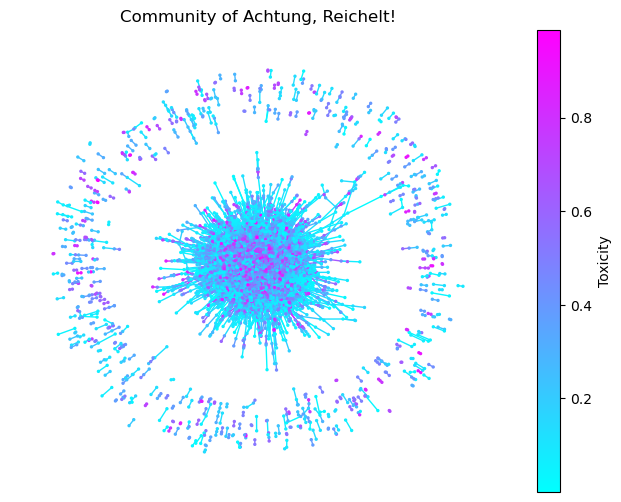

Processing Channels:  33%|███▎      | 1/3 [06:26<12:53, 386.86s/it]

4/4



100%|██████████| 7502/7502 [00:35<00:00, 212.34it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


1/4
2/4
3/4


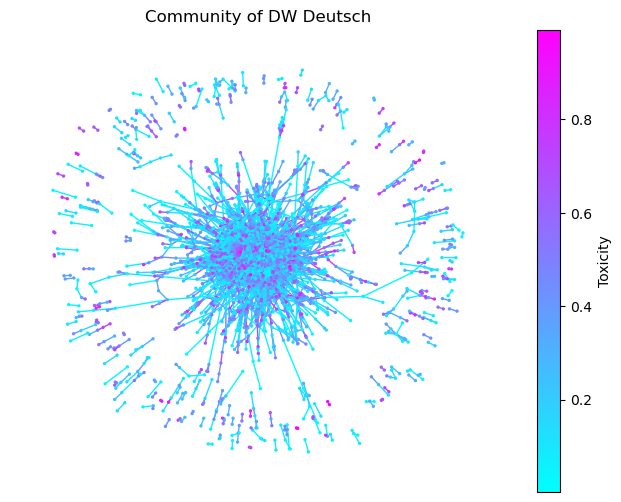

Processing Channels:  67%|██████▋   | 2/3 [07:31<03:17, 197.53s/it]

4/4



100%|██████████| 5109/5109 [00:24<00:00, 206.15it/s]


1/4
2/4
3/4


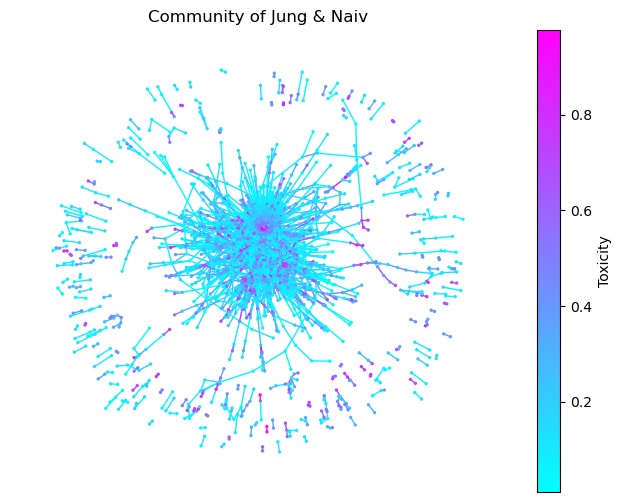

Processing Channels: 100%|██████████| 3/3 [08:12<00:00, 164.07s/it]

4/4


In [6]:
'''
Undirected graph for all comments per Channel.
Edge weights are mean toxicity
'''



# Use tqdm to create a progress bar
progress_bar = tqdm(grouped_data, total=len(grouped_data), desc='Processing Channels')


#plot graphs with toxicity_score
for channel_name, channel_data in progress_bar:
    
    # Create an empty directed graph
    G = nx.Graph()

    # Add nodes (users) to the graph
    G.add_nodes_from(channel_data['authorID'].unique())
    
    # Add edges (interactions) to the graph
    for _, row in tqdm(channel_data.iterrows(), total = len(channel_data)):
        if row['authorID'] != row['parentID'] and row['parentID'] !='0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'toxicity' in edge:
                edge['toxicity'].append(row['toxicity'])
            else:
                edge['toxicity'] = [row['toxicity']]
        
        # Check if repliedID is not equal to 0
        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            # Add additional edges between authorID and each repliedID
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'toxicity' in edge:
                    edge['toxicity'].append(row['toxicity'])
                else:
                    edge['toxicity'] = [row['toxicity']]

                
    print("1/4")
    
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    for u, v, attr in G.edges(data=True):
        if 'toxicity' in attr:
            attr['weight'] = np.mean(attr['toxicity'], dtype=object)
            
    # Calculate the mean toxicity for each node's edges and set it as a node attribute
    for node in G.nodes():
        node_edges = G.edges(node, data=True)
        if node_edges:
            mean_toxicity = np.mean([data.get('toxicity', 0) for _, _, data in node_edges], dtype=object)
            G.nodes[node]['mean_toxicity'] = mean_toxicity
    
    print("2/4")
    
    
    # Calculate the node positions using the spring layout
    pos = nx.spring_layout(G)
    
    edge_cmap = cm.get_cmap('cool') 

    edge_colors = [G[u][v].get('weight', 1.0) for u, v in G.edges()]
    
    # Get the mean_toxicity values from the nodes
    mean_toxicity_values = [data['mean_toxicity'] for _, data in G.nodes(data=True)]

    # Convert the list to a numpy array
    mean_toxicity_array = np.array(mean_toxicity_values)

    node_colors = []
    for i in mean_toxicity_array:
        try:
            i = float(i)
            node_colors.append(i)
        except:
            node_colors.append(i.mean())
    
    print("3/4")


    plt.figure(figsize=(8, 6))
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    cmap = cm.get_cmap('cool')  # Choose the colormap (e.g., cool, jet, etc.)
    nx.draw_networkx(G, pos, node_size=2, edge_color=edge_colors, edge_cmap=cmap, font_size=8, with_labels=False, node_color=node_colors, cmap = cmap)
    plt.title(f"Community of {channel_name}")
    plt.axis('off')
    
    # Add color spectrum bar
    sm = cm.ScalarMappable(cmap=cmap)
    sm.set_array(edge_colors)
    cbar = plt.colorbar(sm)
    cbar.set_label('Toxicity')
    
     # Save the plot with the title
    plt.savefig(f"plots/community_{channel_name}.png")
    plt.show()
    print("4/4")

    
  
        
    
    


100%|██████████| 38844/38844 [02:08<00:00, 302.28it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\sapeer\AppData\Local\Temp\ipykernel_9916\1812257252.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_toxicity_array = np.array(mean_toxicity_values)
100%|██████████| 7502/7502 [00:32<00:00, 231.90it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

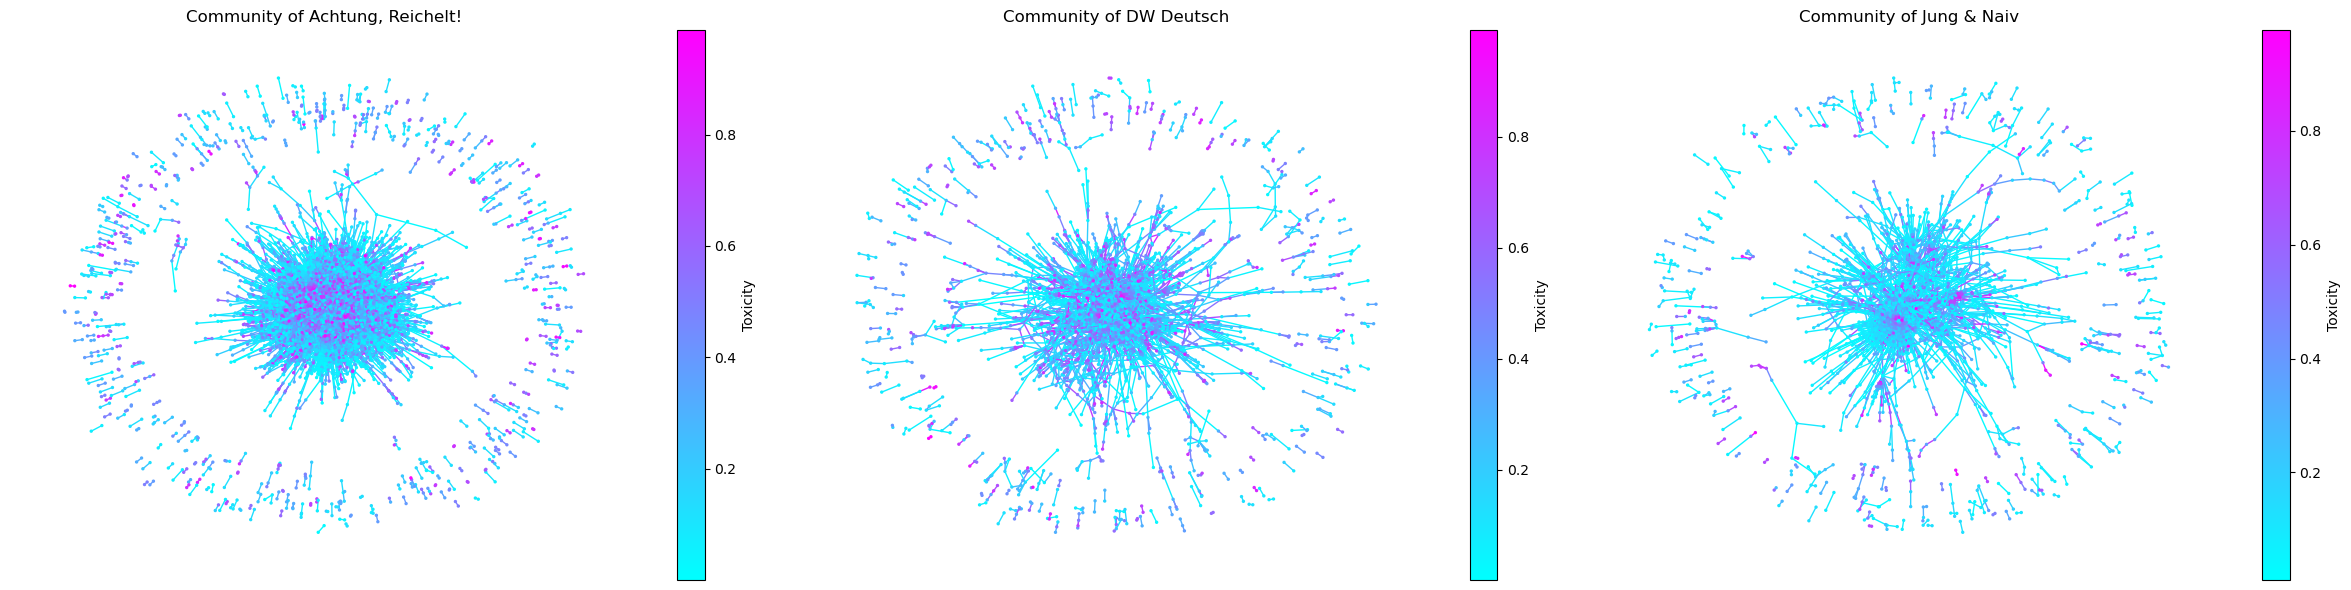

In [6]:
# Create a subplot for all plots
num_channels = len(grouped_data)
fig, axs = plt.subplots(1, num_channels, figsize=(num_channels * 8, 6))

# Loop through each channel and plot the graph
for ax, (channel_name, channel_data) in zip(axs, grouped_data):

    # Create an empty undirected graph
    G = nx.Graph()

    # Add nodes (users) to the graph
    G.add_nodes_from(channel_data['authorID'].unique())

    # Add edges (interactions) to the graph
    for _, row in tqdm(channel_data.iterrows(), total = len(channel_data)):
        if row['authorID'] != row['parentID'] and row['parentID'] !='0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'toxicity' in edge:
                edge['toxicity'].append(row['toxicity'])
            else:
                edge['toxicity'] = [row['toxicity']]
        
        # Check if repliedID is not equal to 0
        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            # Add additional edges between authorID and each repliedID
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'toxicity' in edge:
                    edge['toxicity'].append(row['toxicity'])
                else:
                    edge['toxicity'] = [row['toxicity']]

    for u, v, attr in G.edges(data=True):
        if 'toxicity' in attr:
            attr['weight'] = np.mean(attr['toxicity'])
            
    # Calculate the mean toxicity for each node's edges and set it as a node attribute
    for node in G.nodes():
        node_edges = G.edges(node, data=True)
        if node_edges:
            mean_toxicity = np.mean([data.get('toxicity', 0) for _, _, data in node_edges], dtype=object)
            G.nodes[node]['mean_toxicity'] = mean_toxicity
    
            
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)

    pos = nx.spring_layout(G)
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    cmap = cm.get_cmap('cool')
    
    # Get the mean_toxicity values from the nodes
    mean_toxicity_values = [data['mean_toxicity'] for _, data in G.nodes(data=True)]

    # Convert the list to a numpy array
    mean_toxicity_array = np.array(mean_toxicity_values)

    node_colors = []
    for i in mean_toxicity_array:
        try:
            i = float(i)
            node_colors.append(i)
        except:
            node_colors.append(i.mean())

    nx.draw_networkx(
        G,
        pos,
        node_size=2,
        edge_color=edge_colors,
        edge_cmap=cmap,
        font_size=8,
        node_color=node_colors,
        cmap=cmap,
        with_labels=False,
        ax=ax
    )
    ax.set_title(f"Community of {channel_name}")
    ax.axis('off')

    # Add color spectrum bar
    sm = cm.ScalarMappable(cmap=cmap)
    sm.set_array(edge_colors)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Toxicity')

# Adjust the layout of subplots
plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig(f"plots/community_all.png")
plt.show()

100%|██████████| 38844/38844 [02:21<00:00, 273.65it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


1/4


100%|██████████| 7502/7502 [00:37<00:00, 199.86it/s]


1/4


100%|██████████| 5109/5109 [00:31<00:00, 160.89it/s]


1/4


Processing Channels: 100%|██████████| 3/3 [03:34<00:00, 71.56s/it]


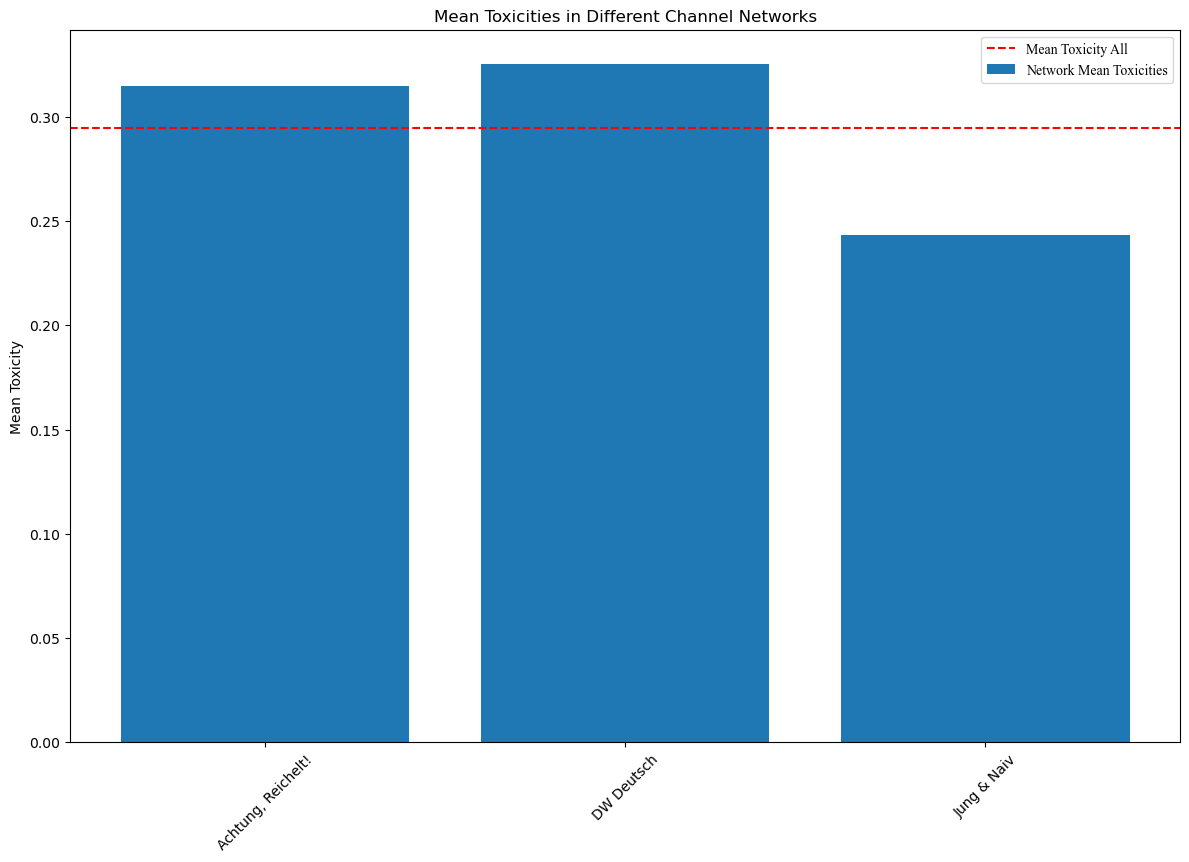

In [6]:
'''
This code calculates cliques using net lovain algortihm. Additionaly we calculate the mean toxicity of the cliques, the difference
to the mean toxicity of the whole network and visualize those.
'''

# Create a color map for channels
channel_colors = {
    'Achtung, Reichelt!': 'blue',
    'DW Deutsch': 'orange',
    'Jung & Naiv': 'green',
    # Add more channels and colors as needed
}

# Initialize variables to store mean toxicities
mean_toxicities = []
#dict to identifie users in big clusters
above_average_users = {}
zero_difference_plotted = False

#lists that i use later on for plotting the clusters
all1 = []
all2 = []
all3 = []



# Create a figure and two subplots
plt.figure(figsize=(12, 16))
# First subplot for cluster-to-channel difference
plt.subplot(2, 1, 1)

# Use tqdm to create a progress bar
progress_bar = tqdm(grouped_data, total=len(grouped_data), desc='Processing Channels')

# Iterate through the channels
for idx, (channel_name, channel_data) in enumerate(progress_bar):

    channel_color = channel_colors.get(channel_name, 'gray')  # Default to gray if channel color not specified

            
    # Create an empty directed graph
    G = nx.Graph()

    # Add nodes (users) to the graph
    G.add_nodes_from(channel_data['authorID'].unique())
    
    # Add edges (interactions) to the graph
    for _, row in tqdm(channel_data.iterrows(), total = len(channel_data)):
        if row['authorID'] != row['parentID'] and row['parentID'] !='0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'toxicity' in edge:
                edge['toxicity'].append(row['toxicity'])
            else:
                edge['toxicity'] = [row['toxicity']]
        
        # Check if repliedID is not equal to 0
        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            # Add additional edges between authorID and each repliedID
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'toxicity' in edge:
                    edge['toxicity'].append(row['toxicity'])
                else:
                    edge['toxicity'] = [row['toxicity']]

                
    print("1/4")
    
    # Remove edges that point to themself (Authors that are first level and reply in second level)
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    for u, v, attr in G.edges(data=True):
        #doesnt work so we take mean later safe all values here
        attr['weight'] = np.mean(attr['toxicity'], dtype=object)
            
    # Calculate the mean toxicity for each node's edges and set it as a node attribute
    for node in G.nodes():
        node_edges = G.edges(node, data=True)
        mean_toxicity = np.mean([data.get('toxicity', 0) for _, _, data in node_edges], dtype=object)
        #doesnt work so we take mean later and safe all values here
        G.nodes[node]['mean_toxicity'] = mean_toxicity
    
    network_mean_toxicity = []
    
    # Update the network mean toxicity list
    network_mean_toxicity.extend([G.nodes[node]['mean_toxicity'] for node in G.nodes()])   
    
    #get all mean values
    mean_network = []
    
    for i in network_mean_toxicity:
        try:
            i = float(i)
            mean_network.append(i)
        except:
            mean_network.append(i.mean())
     
    #calculare whole mean
    mean_tox_channel = np.mean(mean_network)
    
    mean_toxicities.append(mean_tox_channel)
    
    # Find clusters using Louvain algorithm
    partition = community.best_partition(G)
    
    cluster_names = []

    # Calculate mean toxicities within each cluster
    cluster_mean_toxicities = []
    for cluster_id in set(partition.values()):
        cluster_nodes = [node for node, cluster in partition.items() if cluster == cluster_id]
        
        # Only consider clusters with more than 10 nodes
        if len(cluster_nodes) > 10:
            #get mean toxicity of clusters
            cluster_mean_toxicity = np.mean([G.edges[u, v]['weight'] for u, v in G.subgraph(cluster_nodes).edges()])
            cluster_mean_toxicities.append(cluster_mean_toxicity)
            cluster_names.append(cluster_nodes)
            above_average_users[tuple(cluster_nodes)] = cluster_mean_toxicity

    # Calculate the difference in mean toxicity within clusters and the channel mean
    cluster_to_channel_difference = np.array(cluster_mean_toxicities) - np.mean(mean_network)
    
    all1.append(cluster_to_channel_difference)
    all2.append(channel_name)
    all3.append(cluster_names)

# Calculate the overall mean toxicity
all_mean = np.mean(mean_toxicities)

# Set the font family
plt.rcParams["font.family"] = "Times New Roman"

# Create a bar plot for mean toxicities
plt.bar(range(len(mean_toxicities)), mean_toxicities, label='Network Mean Toxicities')

# Add a dashed line for the overall mean toxicity
plt.axhline(y=all_mean, color='r', linestyle='dashed', label='Mean Toxicity All')

# Set x-axis tick labels
plt.xticks(range(len(mean_toxicities)), [channel_name for channel_name, _ in grouped_data], rotation=45)

# Set y-axis label and plot title
plt.ylabel('Mean Toxicity')
plt.title('Mean Toxicities in Different Channel Networks')

# Add a legend
plt.legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(f"plots/mean_tox_network_all.png")

# Display the plot
plt.show()


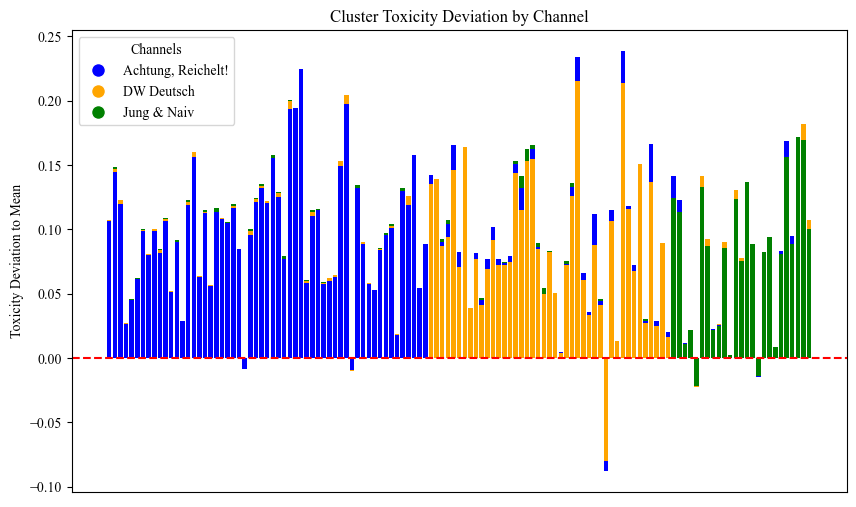

In [7]:
'''
This part visualizes the clusters from each channel
'''
# Define colors
colors = ['blue', 'orange', 'green']
# Initialize the handles list for the legend
handles = []

# Create a dictionary to store cluster data
cluster_data = {}
for i, channel in enumerate(all2):
    clusters = all3[i]
    for j, cluster in enumerate(clusters):
        cluster_id = f"{channel}_Cluster_{j}"
        cluster_data[cluster_id] = {
            "toxicity": all1[i][j],  # Corrected indexing here
            "ids": cluster,
            "color": i  # Assign color index to each cluster
        }

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, channel in enumerate(all2):
    for j, cluster in enumerate(all3[i]):
        cluster_id = f"{channel}_Cluster_{j}"
        cluster_color = colors[cluster_data[cluster_id]["color"]]  # Get color based on color index
        cluster_size = len(cluster)
        toxicity = cluster_data[cluster_id]["toxicity"]

        # Calculate the percentage of colors from other channels
        other_colors = [0, 0, 0]
        for other_id, other_data in cluster_data.items():
            if other_id != cluster_id:
                intersect = set(cluster).intersection(other_data["ids"])
                if intersect:
                    other_channel_index = all2.index(other_id.split('_')[0])
                    other_color = colors[other_data["color"]]
                    other_colors[other_data["color"]] += len(intersect) / cluster_size

        # Plot the bar
        bar = ax.bar(cluster_id, toxicity, color=cluster_color)
        handles.append(bar[0])  # Add bar to custom legend

        for c, pct in enumerate(other_colors):
            if pct > 0:
                ax.bar(cluster_id, toxicity * pct, color=colors[c], bottom=toxicity * (1 - pct))

# Configure plot aesthetics
ax.set_ylabel('Toxicity Deviation to Mean')
ax.set_title('Cluster Toxicity Deviation by Channel')
ax.set_xticks([])

# Create custom legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=channel, markersize=10, markerfacecolor=colors[i]) for i, channel in enumerate(all2)]
ax.legend(handles=legend_handles, title="Channels")
plt.axhline(y=0, color='r', linestyle='dashed', label='Zero Difference')
plt.savefig(f"plots/cluster_all.png")
plt.show()

In [6]:
'''
create cluster variabels
'''

df = pd.read_csv('data/comments_final.csv')
# Create an empty dictionary to store cluster values
cluster_values_dict = {user_id: [] for user_id in df['authorID'].unique()}

# Populate the cluster values dictionary
for key, value in above_average_users.items():
    for i in key:
        if i in cluster_values_dict:
            cluster_values_dict[i].append(value)

# Assign the cluster values from the dictionary to the DataFrame
df["cluster_values"] = df["authorID"].map(cluster_values_dict)

# Calculate cluster mean efficiently
df["cluster"] = df["cluster_values"].apply(lambda x: np.mean(x) if x else 0)

df["in_cluster"] = df["cluster"].apply(lambda x: 1 if x > 0 else 0)

#df.to_csv("data/comments_final.csv", index = False)

In [ ]:
df

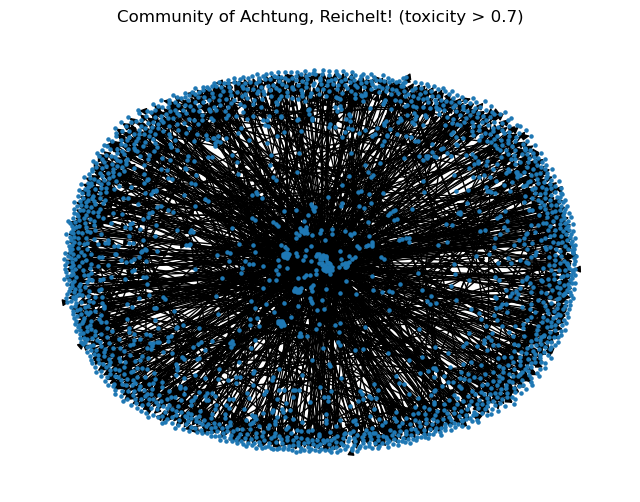

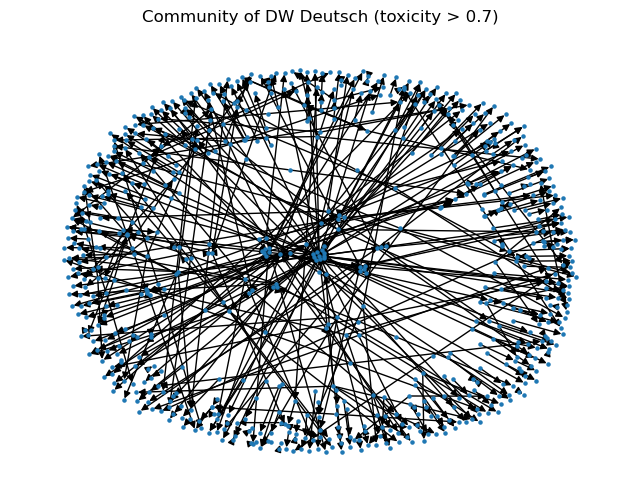

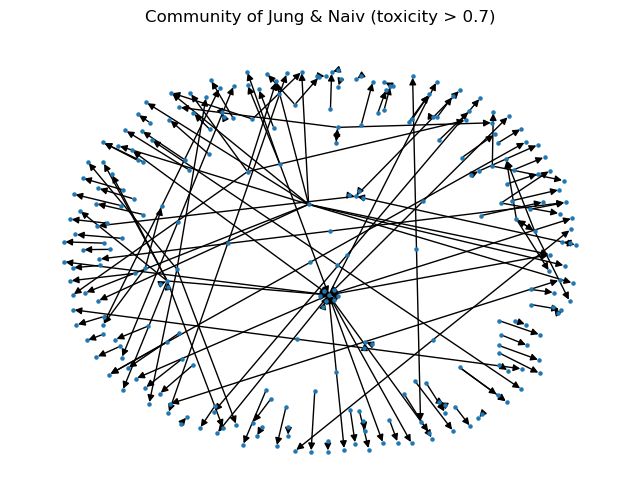

In [11]:
'''
Directed graph for all comments per Channel which have toxicity probability of 0.7 or higher.
No edge weight
'''
df1 = graph_data[graph_data['toxicity'] >= 0.7]
df1 = df1.groupby('channelName')


#plot graphs with toxicity_score
for channel_name, channel_data in df1:
    
    # Create an empty directed graph
    G = nx.DiGraph()

    # Add nodes (users) to the graph
    G.add_nodes_from(channel_data['authorID'].unique())

     # Add edges (interactions) to the graph
    for _, row in channel_data.iterrows():
        if row['authorID'] != row['parentID'] and row['parentID'] !='0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'toxicity' in edge:
                edge['toxicity'].append(row['toxicity'])
            else:
                edge['toxicity'] = [row['toxicity']]
        
        # Check if repliedID is not equal to 0
        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            # Add additional edges between authorID and each repliedID
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'toxicity' in edge:
                    edge['toxicity'].append(row['toxicity'])
                else:
                    edge['toxicity'] = [row['toxicity']]

    
    for u, v, attr in G.edges(data=True):
        if 'toxicity' in attr:
            attr['weight'] = np.mean(attr['toxicity'])
            
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    # Calculate the node positions using the spring layout
    pos = nx.spring_layout(G)
    

    plt.figure(figsize=(8, 6))
    nx.draw_networkx(G, pos, node_size=5, font_size=8, with_labels=False)
    plt.title(f"Community of {channel_name} (toxicity > 0.7)")
    plt.axis('off')
       
     # Save the plot with the title
    plt.savefig(f"plots/tox_community_{channel_name}.png")
    plt.show()



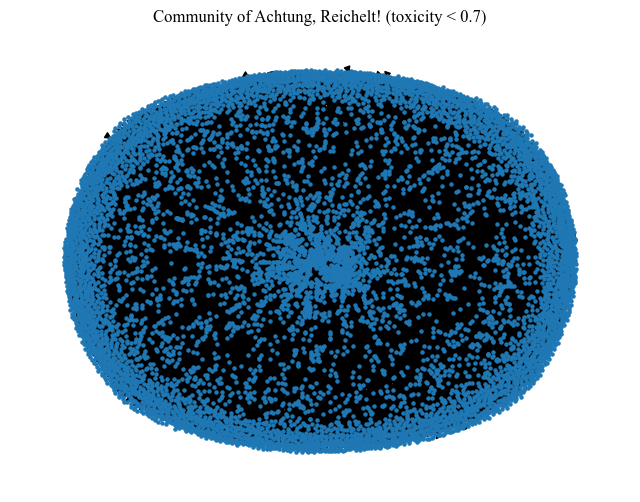

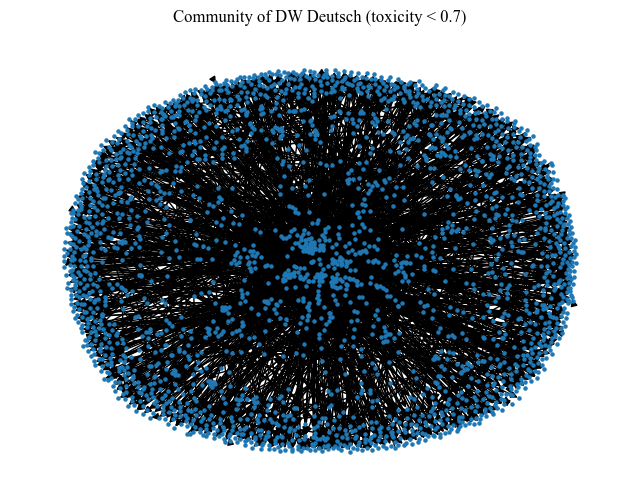

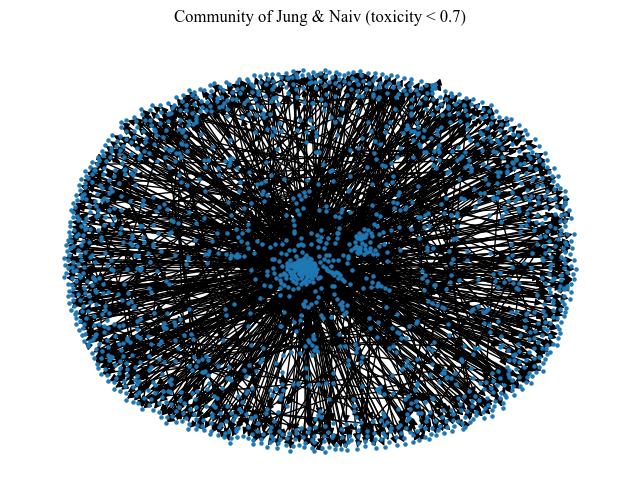

In [8]:
'''
Directed graph for all comments per Channel which have toxicity probability lower than 0.7.
No edge weight
'''

df2 = graph_data[graph_data['toxicity'] < 0.7]
df2 = df2.groupby('channelName')


#plot graphs with toxicity_score
for channel_name, channel_data in df2:
    
    # Create an empty directed graph
    G = nx.DiGraph()

    # Add nodes (users) to the graph
    G.add_nodes_from(channel_data['authorID'].unique())

     # Add edges (interactions) to the graph
    for _, row in channel_data.iterrows():
        if row['authorID'] != row['parentID'] and row['parentID'] !='0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'toxicity' in edge:
                edge['toxicity'].append(row['toxicity'])
            else:
                edge['toxicity'] = [row['toxicity']]
        
        # Check if repliedID is not equal to 0
        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            # Add additional edges between authorID and each repliedID
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'toxicity' in edge:
                    edge['toxicity'].append(row['toxicity'])
                else:
                    edge['toxicity'] = [row['toxicity']]

    
    for u, v, attr in G.edges(data=True):
        if 'toxicity' in attr:
            attr['weight'] = np.mean(attr['toxicity'])
            
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    
    # Calculate the node positions using the spring layout
    pos = nx.spring_layout(G)
    

    plt.figure(figsize=(8, 6))
    nx.draw_networkx(G, pos, node_size=5, font_size=8, with_labels=False)
    plt.title(f"Community of {channel_name} (toxicity < 0.7)")
    plt.axis('off')
       
     # Save the plot with the title
    plt.savefig(f"plots/nontox_community_{channel_name}.png")
    plt.show()



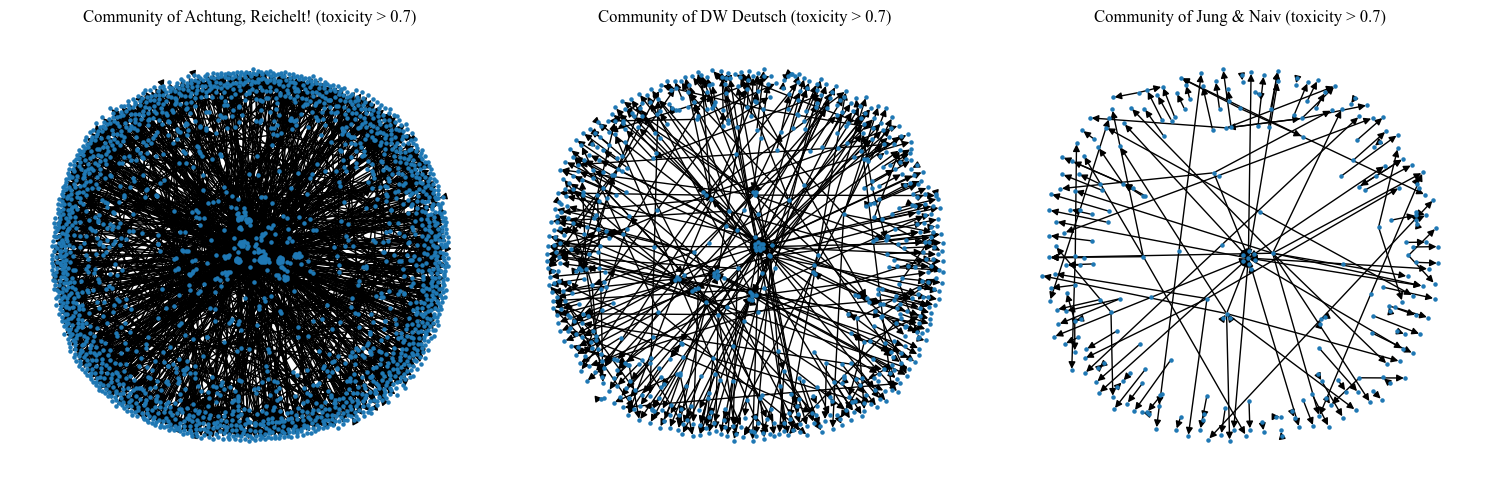

In [9]:
# Filter data with toxicity >= 0.7 and group by channel
df1 = graph_data[graph_data['toxicity'] >= 0.7]
grouped_data = df1.groupby('channelName')

# Create a subplot for all plots
fig, axs = plt.subplots(1, len(grouped_data), figsize=(15, 5))

# Plot graphs with toxicity_score
for ax, (channel_name, channel_data) in zip(axs, grouped_data):
    
    # Create an empty directed graph
    G = nx.DiGraph()

    # Add nodes (users) to the graph
    G.add_nodes_from(channel_data['authorID'].unique())

    # Add edges (interactions) to the graph
    for _, row in channel_data.iterrows():
        if row['authorID'] != row['parentID'] and row['parentID'] != '0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'toxicity' in edge:
                edge['toxicity'].append(row['toxicity'])
            else:
                edge['toxicity'] = [row['toxicity']]
        
        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'toxicity' in edge:
                    edge['toxicity'].append(row['toxicity'])
                else:
                    edge['toxicity'] = [row['toxicity']]

    for u, v, attr in G.edges(data=True):
        if 'toxicity' in attr:
            attr['weight'] = np.mean(attr['toxicity'])
            
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    # Calculate the node positions using the spring layout
    pos = nx.spring_layout(G)
    
    # Draw the graph in the subplot
    nx.draw_networkx(G, pos, ax=ax, node_size=5, font_size=8, with_labels=False)
    ax.set_title(f"Community of {channel_name} (toxicity > 0.7)")
    ax.axis('off')

# Adjust the layout of subplots
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()
plt.savefig(f"plots/tox_community_all.png")
plt.show()

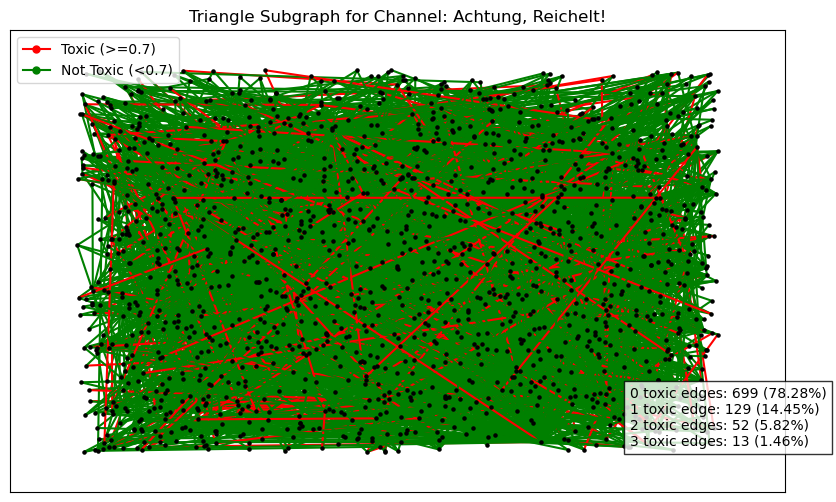

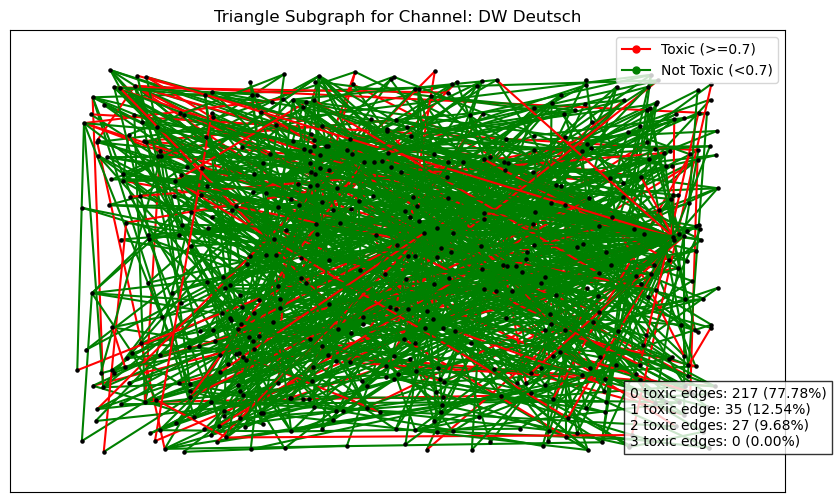

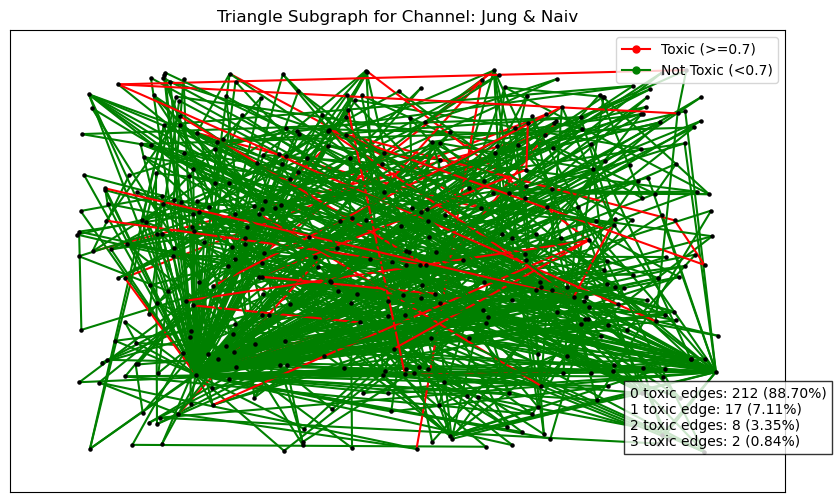

In [18]:
'''
Structural balance using toxicity
'''
grouped_data = graph_data.groupby('channelName')

results1 = []

stable1 = []

#plot graphs with toxicity_score
for channel_name, channel_data in grouped_data:
    
    # Create an empty directed graph
    G = nx.Graph()

    # Add nodes (users) to the graph
    G.add_nodes_from(channel_data['authorID'].unique())

    # Add edges (interactions) to the graph
    for _, row in channel_data.iterrows():
        if row['authorID'] != row['parentID'] and row['parentID'] !='0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'toxicity' in edge:
                edge['toxicity'].append(row['toxicity'])
            else:
                edge['toxicity'] = [row['toxicity']]
        
        # Check if repliedID is not equal to 0
        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            # Add additional edges between authorID and each repliedID
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'toxicity' in edge:
                    edge['toxicity'].append(row['toxicity'])
                else:
                    edge['toxicity'] = [row['toxicity']]

    
    for u, v, attr in G.edges(data=True):
        if 'toxicity' in attr:
            attr['weight'] = np.mean(attr['toxicity'])
            
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    
    # Compute the number of triangles for each node
    triangles = nx.triangles(G)

    # Find the nodes that participate in at least one triangle
    triangle_nodes = [node for node, count in triangles.items() if count > 0]
    
    # Create a subgraph containing only the triangle nodes and their incident edges
    triangle_graph = G.subgraph(triangle_nodes)
    
    # Get the edge colors based on weight
    edge_colors = ['red' if weight >= 0.7 else 'green' for _, _, weight in triangle_graph.edges.data('weight')]
    
    # Count the number of triangles with different numbers of toxic edges
    zero_toxic_count = 0
    one_toxic_count = 0
    two_toxic_count = 0
    three_toxic_count = 0
    total_triangle_count = 0


    # Iterate over all triangles in the graph
    for clique in nx.enumerate_all_cliques(triangle_graph):
        if len(clique) == 3:  # Check if the clique is a triangle
            u, v, w = clique
            if triangle_graph.has_edge(u, v) and triangle_graph.has_edge(u, w) and triangle_graph.has_edge(v, w):
                toxic_edges = sum(triangle_graph.edges[edge]['weight'] > 0.7 for edge in [(u, v), (u, w), (v, w)])

                if toxic_edges == 0:
                    zero_toxic_count += 1
                elif toxic_edges == 1:
                    one_toxic_count += 1
                elif toxic_edges == 2:
                    two_toxic_count += 1
                elif toxic_edges == 3:
                    three_toxic_count += 1
                    
                total_triangle_count += 1
                
            if toxic_edges == 0 or toxic_edges == 2:  # Select triangles with 0 or 2 toxic edges
                stable1.extend(channel_data[channel_data['authorID'].isin([u, v, w])]['commentID'].values)
                    
    # Calculate the percentage values
    zero_toxic_percent = (zero_toxic_count / total_triangle_count) * 100
    one_toxic_percent = (one_toxic_count / total_triangle_count) * 100
    two_toxic_percent = (two_toxic_count / total_triangle_count) * 100
    three_toxic_percent = (three_toxic_count / total_triangle_count) * 100
    
    results1.append({
        "channel_name": channel_name,
        "zero_toxic_count": zero_toxic_count,
        "one_toxic_count": one_toxic_count,
        "two_toxic_count": two_toxic_count,
        "three_toxic_count": three_toxic_count,
        "zero_toxic_percent": zero_toxic_percent,
        "one_toxic_percent": one_toxic_percent,
        "two_toxic_percent": two_toxic_percent,
        "three_toxic_percent": three_toxic_percent,
    })

    # Plot the triangle subgraph
    plt.figure(figsize=(10, 6))
        
    # Create custom legend
    red_patch = plt.Line2D([], [], color='red', marker='o', markersize=5, label='Toxic (>=0.7)')
    green_patch = plt.Line2D([], [], color='green', marker='o', markersize=5, label='Not Toxic (<0.7)')
    plt.legend(handles=[red_patch, green_patch])
    
   # Create custom legend with count and percentage values
    legend_text = (
        f"0 toxic edges: {zero_toxic_count} ({zero_toxic_percent:.2f}%)\n"
        f"1 toxic edge: {one_toxic_count} ({one_toxic_percent:.2f}%)\n"
        f"2 toxic edges: {two_toxic_count} ({two_toxic_percent:.2f}%)\n"
        f"3 toxic edges: {three_toxic_count} ({three_toxic_percent:.2f}%)"
    )
    plt.text(0.8, 0.1, legend_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

    pos = nx.random_layout(triangle_graph)
    nx.draw_networkx(triangle_graph, pos, with_labels=False, node_size=5, node_color='black', edge_color=edge_colors, width=1.5)
    plt.title(f"Triangle Subgraph for Channel: {channel_name}")
    # Save the plot with the title
    plt.savefig(f"plots/triangles_{channel_name}.png")
    plt.show()


100%|██████████| 38844/38844 [01:57<00:00, 330.03it/s]


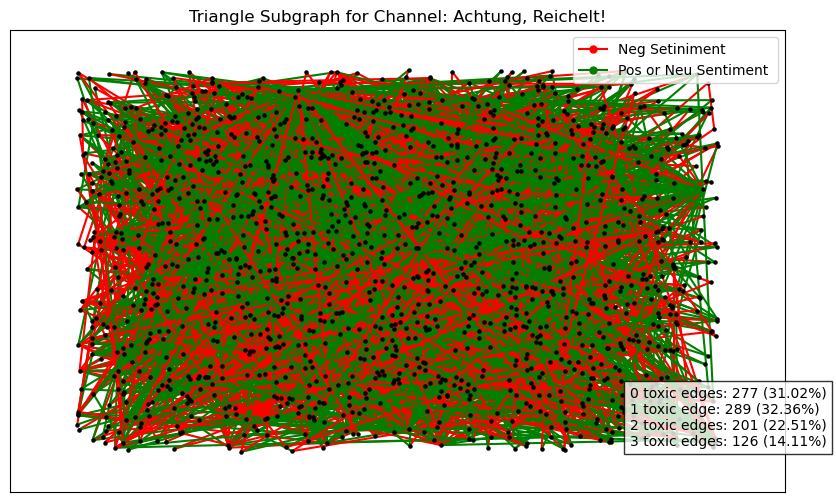

100%|██████████| 7502/7502 [00:30<00:00, 243.99it/s]


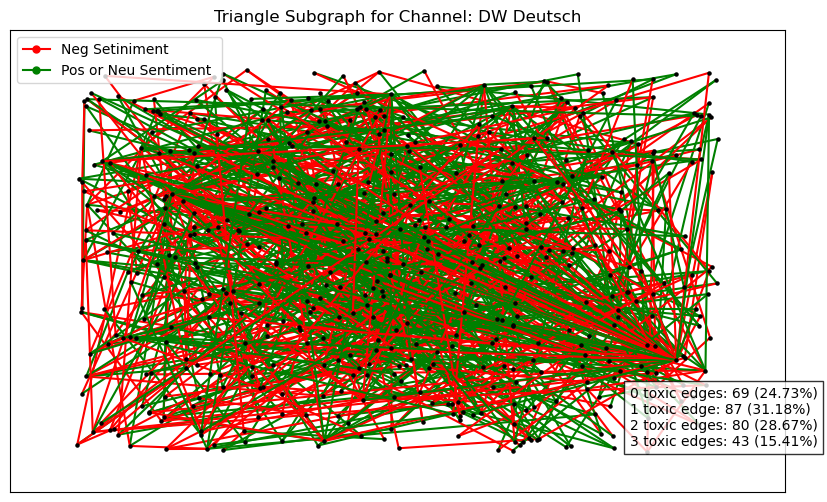

100%|██████████| 5109/5109 [00:23<00:00, 218.92it/s]


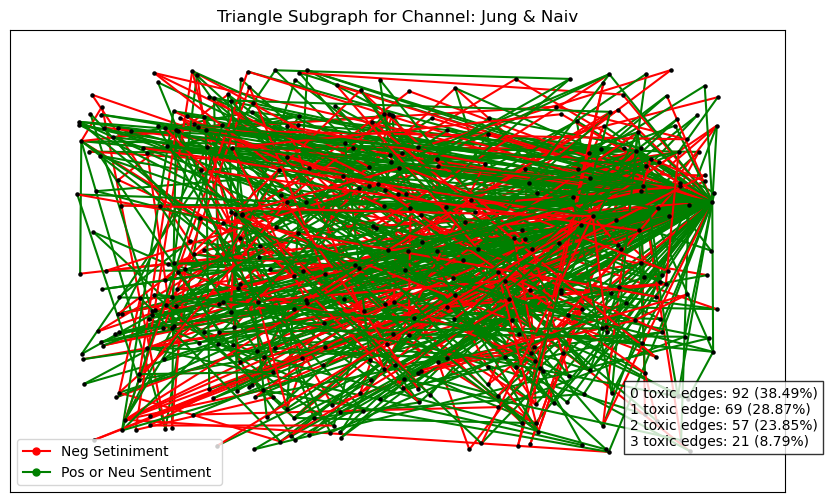

In [20]:
'''
Structural balance using sentiment
'''
stable2 = []
results2 = []

# Plot graphs with prob_neg and prob_pos
for channel_name, channel_data in grouped_data:
    
    G = nx.Graph()
    G.add_nodes_from(channel_data['authorID'].unique())

    for _, row in tqdm(channel_data.iterrows(), total = len(channel_data)):
        if row['authorID'] != row['parentID'] and row['parentID'] != '0':
            comment_to = df.loc[df['commentID'] == row['parentID'], 'authorID'].values[0]
            G.add_edge(row['authorID'], comment_to)
            edge = G.edges[row['authorID'],  comment_to]
            if 'prob_pos' in edge:
                edge['prob_pos'].append(row['prob_pos'])
                edge['prob_neg'].append(row['prob_neg'])
                edge['prob_neu'].append(row['prob_neu'])
            else:
                edge['prob_pos'] = [row['prob_pos']]
                edge['prob_neg'] = [row['prob_neg']]
                edge['prob_neu'] = [row['prob_neu']]

        if pd.notnull(row['repliedName']) and row['authorID'] != row['repliedID']:
            for replied_id in row["repliedID"].split():
                G.add_edge(row['authorID'], replied_id)
                edge = G.edges[row['authorID'], replied_id]
                if 'prob_pos' in edge:
                    edge['prob_pos'].append(row['prob_pos'])
                    edge['prob_neg'].append(row['prob_neg'])
                    edge['prob_neu'].append(row['prob_neu'])
                else:
                    edge['prob_pos'] = [row['prob_pos']]
                    edge['prob_neg'] = [row['prob_neg']]
                    edge['prob_neu'] = [row['prob_neu']]

    for u, v, attr in G.edges(data=True):
        if 'prob_pos' in attr:
            attr['weight_pos'] = np.mean(attr['prob_pos'], dtype= object)
            attr['weight_neg'] = np.mean(attr['prob_neg'], dtype= object)
            attr['weight_neu'] = np.mean(attr['prob_neu'], dtype= object)
            
    self_loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loop_edges)
    
    # Remove nodes with no edges
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    triangles = nx.triangles(G)
    triangle_nodes = [node for node, count in triangles.items() if count > 0]
    triangle_graph = G.subgraph(triangle_nodes)
    
    edge_colors = ['red' if np.mean((weight['prob_neg'])) > np.mean((weight['prob_pos'])) and np.mean((weight['prob_neg'])) > np.mean((weight['prob_neu']))
                   else 'green' for _, _, weight in triangle_graph.edges(data=True)]
    
    # Count the number of triangles with different numbers of "toxic" edges
    zero_toxic_count = 0
    one_toxic_count = 0
    two_toxic_count = 0
    three_toxic_count = 0
    total_triangle_count = 0

    # Iterate over all triangles in the graph
    for clique in nx.enumerate_all_cliques(triangle_graph):
        if len(clique) == 3:  # Check if the clique is a triangle
            u, v, w = clique
            if triangle_graph.has_edge(u, v) and triangle_graph.has_edge(u, w) and triangle_graph.has_edge(v, w):
                toxic_edges = sum(
                    triangle_graph.edges[edge]['weight_neg'] > triangle_graph.edges[edge]['weight_pos'] and triangle_graph.edges[edge]['weight_neg'] > triangle_graph.edges[edge]['weight_neu']
                    for edge in [(u, v), (u, w), (v, w)]
                )

                if toxic_edges == 0:
                    zero_toxic_count += 1
                elif toxic_edges == 1:
                    one_toxic_count += 1
                elif toxic_edges == 2:
                    two_toxic_count += 1
                elif toxic_edges == 3:
                    three_toxic_count += 1

                total_triangle_count += 1

            if toxic_edges == 0 or toxic_edges == 2:  # Select triangles with 0 or 2 "toxic" edges
                stable2.extend(
                    channel_data[channel_data['authorID'].isin([u, v, w])]['commentID'].values
                )

    # Calculate the percentage values
    zero_toxic_percent = (zero_toxic_count / total_triangle_count) * 100
    one_toxic_percent = (one_toxic_count / total_triangle_count) * 100
    two_toxic_percent = (two_toxic_count / total_triangle_count) * 100
    three_toxic_percent = (three_toxic_count / total_triangle_count) * 100
    
    results2.append({
        "channel_name": channel_name,
        "zero_toxic_count": zero_toxic_count,
        "one_toxic_count": one_toxic_count,
        "two_toxic_count": two_toxic_count,
        "three_toxic_count": three_toxic_count,
        "zero_toxic_percent": zero_toxic_percent,
        "one_toxic_percent": one_toxic_percent,
        "two_toxic_percent": two_toxic_percent,
        "three_toxic_percent": three_toxic_percent,
    })

    
    # Plot the triangle subgraph
    plt.figure(figsize=(10, 6))
        
    # Create custom legend
    red_patch = plt.Line2D([], [], color='red', marker='o', markersize=5, label='Neg Setiniment')
    green_patch = plt.Line2D([], [], color='green', marker='o', markersize=5, label='Pos or Neu Sentiment ')
    plt.legend(handles=[red_patch, green_patch])
    
   # Create custom legend with count and percentage values
    legend_text = (
        f"0 toxic edges: {zero_toxic_count} ({zero_toxic_percent:.2f}%)\n"
        f"1 toxic edge: {one_toxic_count} ({one_toxic_percent:.2f}%)\n"
        f"2 toxic edges: {two_toxic_count} ({two_toxic_percent:.2f}%)\n"
        f"3 toxic edges: {three_toxic_count} ({three_toxic_percent:.2f}%)"
    )
    plt.text(0.8, 0.1, legend_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

    pos = nx.random_layout(triangle_graph)
    nx.draw_networkx(triangle_graph, pos, with_labels=False, node_size=5, node_color='black', edge_color=edge_colors, width=1.5)
    plt.title(f"Triangle Subgraph for Channel: {channel_name}")
    # Save the plot with the title
    plt.savefig(f"plots/triangles_sent{channel_name}.png")
    plt.show()

In [41]:
'''
create result table for structural balance
'''
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import pandas as pd
from dash.dependencies import Input, Output
import plotly.graph_objs as go

for i in results1:
    i["structural balance"] = i['zero_toxic_percent'] + i['two_toxic_percent']

for i in results2:
    i["structural balance"] = i['zero_toxic_percent'] + i['two_toxic_percent']


app = dash.Dash(__name__)

# Data preparation (same as before)
channel_names = [entry['channel_name'] for entry in results1]
structural_balance_results1 = [entry['structural balance'] for entry in results1]
structural_balance_results2 = [entry['structural balance'] for entry in results2]
edge_counts = ["zero", "one", "two", "three"]
edge_toxicity = [[entry[f'{edge}_toxic_count'] for entry in results1] for edge in edge_counts]
edge_sentiment = [[entry[f'{edge}_toxic_count'] for entry in results2] for edge in edge_counts]

# Prepare data for the table
data = {'Channel': channel_names,
        'Structural Balance (Toxicity)': structural_balance_results1,
        'Structural Balance (Sentiment)': structural_balance_results2}

for edge, toxic, sentiment in zip(edge_counts, edge_toxicity, edge_sentiment):
    data[f'{edge} neg edges'] = [f'{toxic_val}, {sentiment_val}' for toxic_val, sentiment_val in zip(toxic, sentiment)]

df = pd.DataFrame(data)

# Create a Dash layout
app.layout = html.Div([
    dcc.Graph(
        id='bar-chart',
        figure={
            'data': [
                go.Bar(x=channel_names, y=structural_balance_results1, name='Using Toxicity'),
                go.Bar(x=channel_names, y=structural_balance_results2, name='Using Sentiment')
            ],
            'layout': go.Layout(
                title='Interactive Structural Balance Comparison by Channel and Method',
                xaxis={'title': 'Channels'},
                yaxis={'title': 'Structural Balance'},
                showlegend=True
            )
        }
    ),
    dash_table.DataTable(
        id='table',
        columns=[{'name': col, 'id': col} for col in df.columns],
        data=df.to_dict('records')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)
    
latex_table = df.to_latex(index=False, escape=False)   




C:\Users\sapeer\AppData\Local\Temp\ipykernel_11976\2411117591.py:57: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [21]:
''' 
crate structural balance variables
'''

data = pd.read_csv('data/comments_final.csv')
#data = data.drop(columns=['stable'])
data['stable_tox'] = 0
data['stable_sent'] = 0
# Split combined IDs and flatten the list
split_ids = [ids.split('.') if '.' in ids else [ids] for ids in stable1]
individual_ids = [sub_id for sublist in split_ids for sub_id in sublist]
unique_ids = list(set(individual_ids))
for i in  tqdm(data["commentID"]):
    if i in unique_ids:
        data.loc[data['commentID'] == i, 'stable_tox'] = 1
        
# Split combined IDs and flatten the list
split_ids = [ids.split('.') if '.' in ids else [ids] for ids in stable2]
individual_ids = [sub_id for sublist in split_ids for sub_id in sublist]
unique_ids = list(set(individual_ids))
for i in  tqdm(data["commentID"]):
    if i in unique_ids:
        data.loc[data['commentID'] == i, 'stable_sent'] = 1

100%|██████████| 134883/134883 [03:41<00:00, 608.51it/s] 


In [26]:
data.to_csv("data/comments_final.csv", index = False)